In [81]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

sys.path.append("/work/gallim/SIMStudies/wipfs/preproce/electrons")
from preprocessing import saturation

In [4]:
input_dir = "/work/gallim/SIMStudies/FlashSimStudies/preprocessing/extracted_photons"
files = [f"{input_dir}/{f}" for f in os.listdir(input_dir)][:10]

df = dd.read_parquet(files).compute()

In [7]:
df.columns

Index(['GenPho_pt', 'GenPho_eta', 'GenPho_phi', 'GenPho_status',
       'GenPho_statusFlags', 'RecoPho_pt', 'RecoPho_eta', 'RecoPho_phi',
       'RecoPho_mass', 'RecoPho_r9', 'RecoPho_sieie', 'RecoPho_eCorr',
       'RecoPho_energyErr', 'RecoPho_hoe', 'RecoPho_mvaID',
       'RecoPho_pfRelIso03_all', 'RecoPho_pfRelIso03_chg',
       'GenPhoGenEle_deltar', 'GenPhoGenEle_deltaphi', 'GenPhoGenEle_deltaeta',
       'GenPhoGenEle_ptratio', 'GenPhoGenJet_deltar', 'GenPhoGenJet_deltaphi',
       'GenPhoGenJet_deltaeta', 'GenPhoGenJet_ptratio', 'RecoPhoGenPho_deltar',
       'RecoPhoGenPho_deltaphi', 'RecoPhoGenPho_deltaeta',
       'RecoPhoGenPho_ptratio', 'ClosestGenJet_pt', 'ClosestGenJet_mass',
       'PU_nTrueInt', 'PU_nPU', 'PU_gpudensity', 'PU_pudensity', 'PU_sumEOOT',
       'PU_sumLOOT'],
      dtype='object')

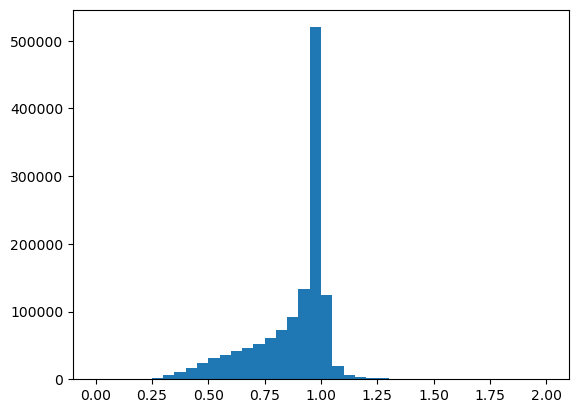

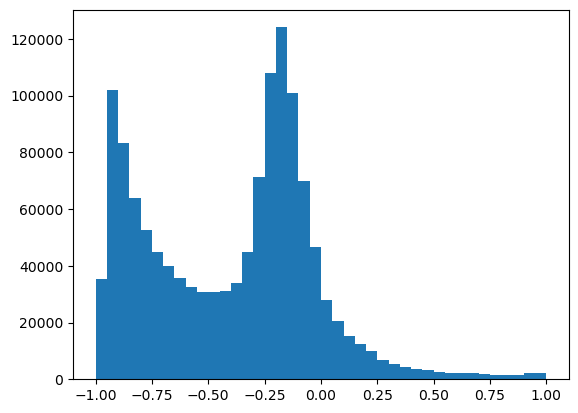

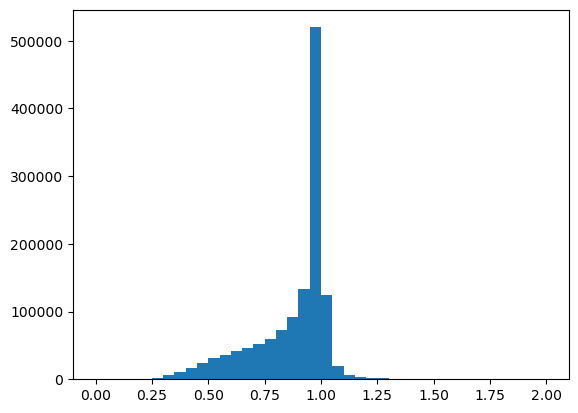

In [61]:
pipe = Pipeline(
    [
        ('log_trans', FunctionTransformer(lambda x: np.log(x + 1e-2), inverse_func=lambda x: np.exp(x) - 1e-2)),
        ('arctan_trans', FunctionTransformer(lambda x: np.arctan(x*10 - 0.15), inverse_func=lambda x: (np.tan(x) + 0.15)/10)),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

r9 = df['RecoPho_r9'].values
plt.hist(r9, bins=40, range=(0, 2));
plt.show()
new_r9 = pipe.fit_transform(r9.reshape(-1, 1))
plt.hist(new_r9, bins=40);
plt.show()
old_r9 = pipe.inverse_transform(new_r9)
plt.hist(old_r9, bins=40, range=(0, 2));

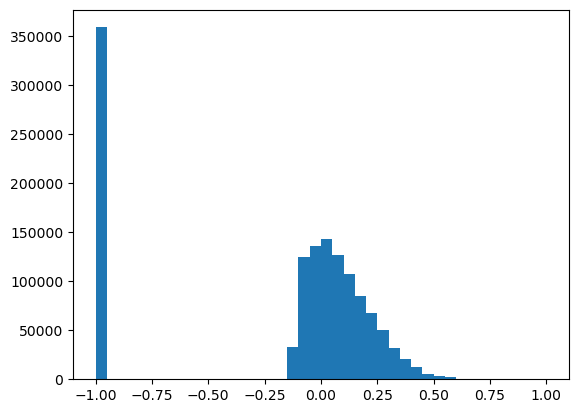

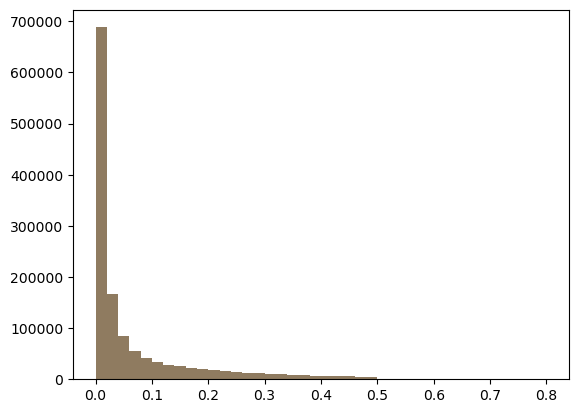

In [87]:
pipe = Pipeline(
    [
        #('log_trans', FunctionTransformer(lambda x: np.log(x + 1e-2), inverse_func=lambda x: np.exp(x) - 1e-2)),
        #('log_trans', FunctionTransformer(np.log1p, inverse_func=np.expm1)),
        #('pow', PowerTransformer()),
        ('qtgaus', QuantileTransformer(output_distribution="normal", n_quantiles=1000, random_state=0)),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

var = df['RecoPho_hoe'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40)
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(old_var, bins=40, range=(0, 0.8));
plt.hist(var, bins=40, range=(0, 0.8), alpha=0.5);

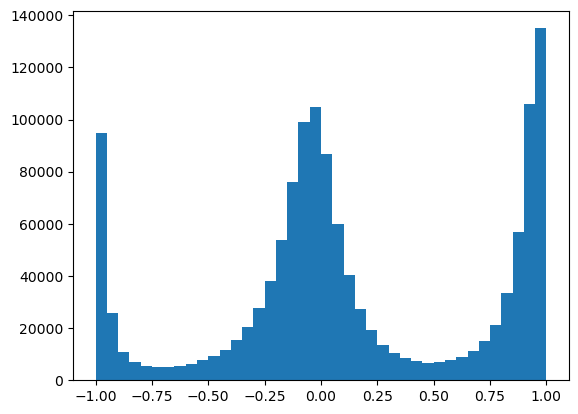

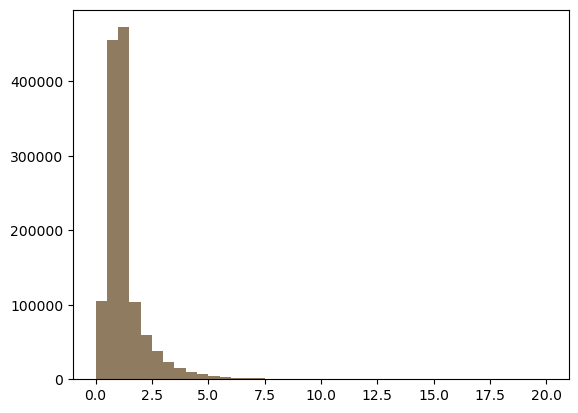

In [95]:
pipe = Pipeline(
    [
        #('log_trans', FunctionTransformer(lambda x: np.log(x + 1e-2), inverse_func=lambda x: np.exp(x) - 1e-2)),
        ('arctan_trans', FunctionTransformer(lambda x: np.arctan(x*10 - 10), inverse_func=lambda x: (np.tan(x) + 10)/10)),
        #('log_trans', FunctionTransformer(np.log1p, inverse_func=np.expm1)),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

var = df['RecoPhoGenPho_ptratio'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40)
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(old_var, bins=40, range=(0, 20));
plt.hist(var, bins=40, range=(0, 20), alpha=0.5);